In [87]:
# test reading in 10x data with AnnData
import pandas as pd
import numpy as np
import scanpy as sc
from glob import glob
import os
import scvi
import pickle
from scipy import sparse
import anndata as ad
import itertools

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("Spectral"))
sns.set_style("whitegrid")

from matplotlib.ticker import StrMethodFormatter
# ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

import requests
from tqdm import tqdm

data_dir = "data"

In [29]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, frameon=False, figsize=(5, 3), facecolor="white")

with open("combined_hs_counts.pkl", "rb") as file:
    hs_combined = pickle.load(file)



In [ ]:
# filter out to just the desired datasets
df = pd.read_excel('sample_list.xlsx')
GSMs = list(df['GSM'][df['Using']])

filtered_hs_counts = hs_combined[hs_combined.obs['GSM'].apply(lambda x: 'GSM'+str(x) in GSMs)]
filtered_hs_counts.obs.index = ['cell_' + str(i) for i in range(filtered_hs_counts.n_obs)]
filtered_hs_counts.obs['GSM'] = filtered_hs_counts.obs['GSM'].astype('category')

with open("filtered_hs_counts.pkl", "wb") as file:
    pickle.dump(filtered_hs_counts, file)
    
filtered_hs_counts

In [74]:
def plot_umap(hs_combined, filename, hue = "batch"):
    fig, ax = plt.subplots(figsize = (10,10))
    uc = hs_combined.obsm['X_umap']
    sns.scatterplot(x = uc[:,0], y = uc[:,1], hue = hs_combined.obs[hue], legend = "full", s = 2, ax = ax)
    ax.set_title(filename)
    ax.legend(markerscale = 5)
    fig.savefig("figures" + '/' + filename + '.png', dpi = 300)
    plt.close()

In [78]:
# plot umaps for each of the three GSEs

def gse_umap(adata, batch, harmony = True):
    temp = adata[adata.obs['batch'] == batch]

    sc.pp.highly_variable_genes(
        temp,
        flavor = "seurat_v3",
        n_top_genes = 3000,
        # inplace subset
        subset = True
    )

    sc.pp.regress_out(temp, ["pct_counts_mt"])
    sc.pp.scale(temp, max_value = 10)
    sc.pp.pca(temp)
    
    if harmony:
        sc.external.pp.harmony_integrate(temp, key = "GSM", basis = 'X_pca')
        sc.pp.neighbors(temp, use_rep = "X_pca_harmony")
        title = "GSE_" + str(batch) + "_harmony"
    else:
        sc.pp.neighbors(temp, use_rep = "X_pca")
        title = "GSE_" + str(batch)

    sc.tl.umap(temp)
    plot_umap(temp, title, hue = "GSM")


In [73]:
list(filtered_hs_counts.obs['batch'].unique())

['220116', '175990', '154775']

In [88]:
for GSE in tqdm(list(filtered_hs_counts.obs['batch'].unique())):
    gse_umap(filtered_hs_counts, GSE)
    gse_umap(filtered_hs_counts, GSE, harmony = False)

c:\Users\randymi\anaconda3\envs\scanpy\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
2024-08-06 02:37:10,010 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-08-06 02:37:10,963 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-08-06 02:37:11,018 - harmonypy - INFO - Iteration 1 of 10
2024-08-06 02:37:13,608 - harmonypy - INFO - Iteration 2 of 10
2024-08-06 02:37:16,285 - harmonypy - INFO - Iteration 3 of 10
2024-08-06 02:37:18,906 - harmonypy - INFO - Iteration 4 of 10
2024-08-06 02:37:21,526 - harmonypy - INFO - Iteration 5 of 10
2024-08-06 02:37:24,081 - harmonypy - INFO - Iteration 6 of 10
2024-08-06 02:37:26,615 - harmonypy - INFO - Iteration 7 of 10
2024-08-06 02:37:29,167 - harmonypy - INFO - Converged after 7 iterations
Exception ignored in: <function tqdm.__del__ at 0x000

In [66]:
filtered_hs_counts

AnnData object with n_obs × n_vars = 50192 × 28232
    obs: 'cell_id', 'GSM', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'

AttributeError: 'NoneType' object has no attribute 'obsm'

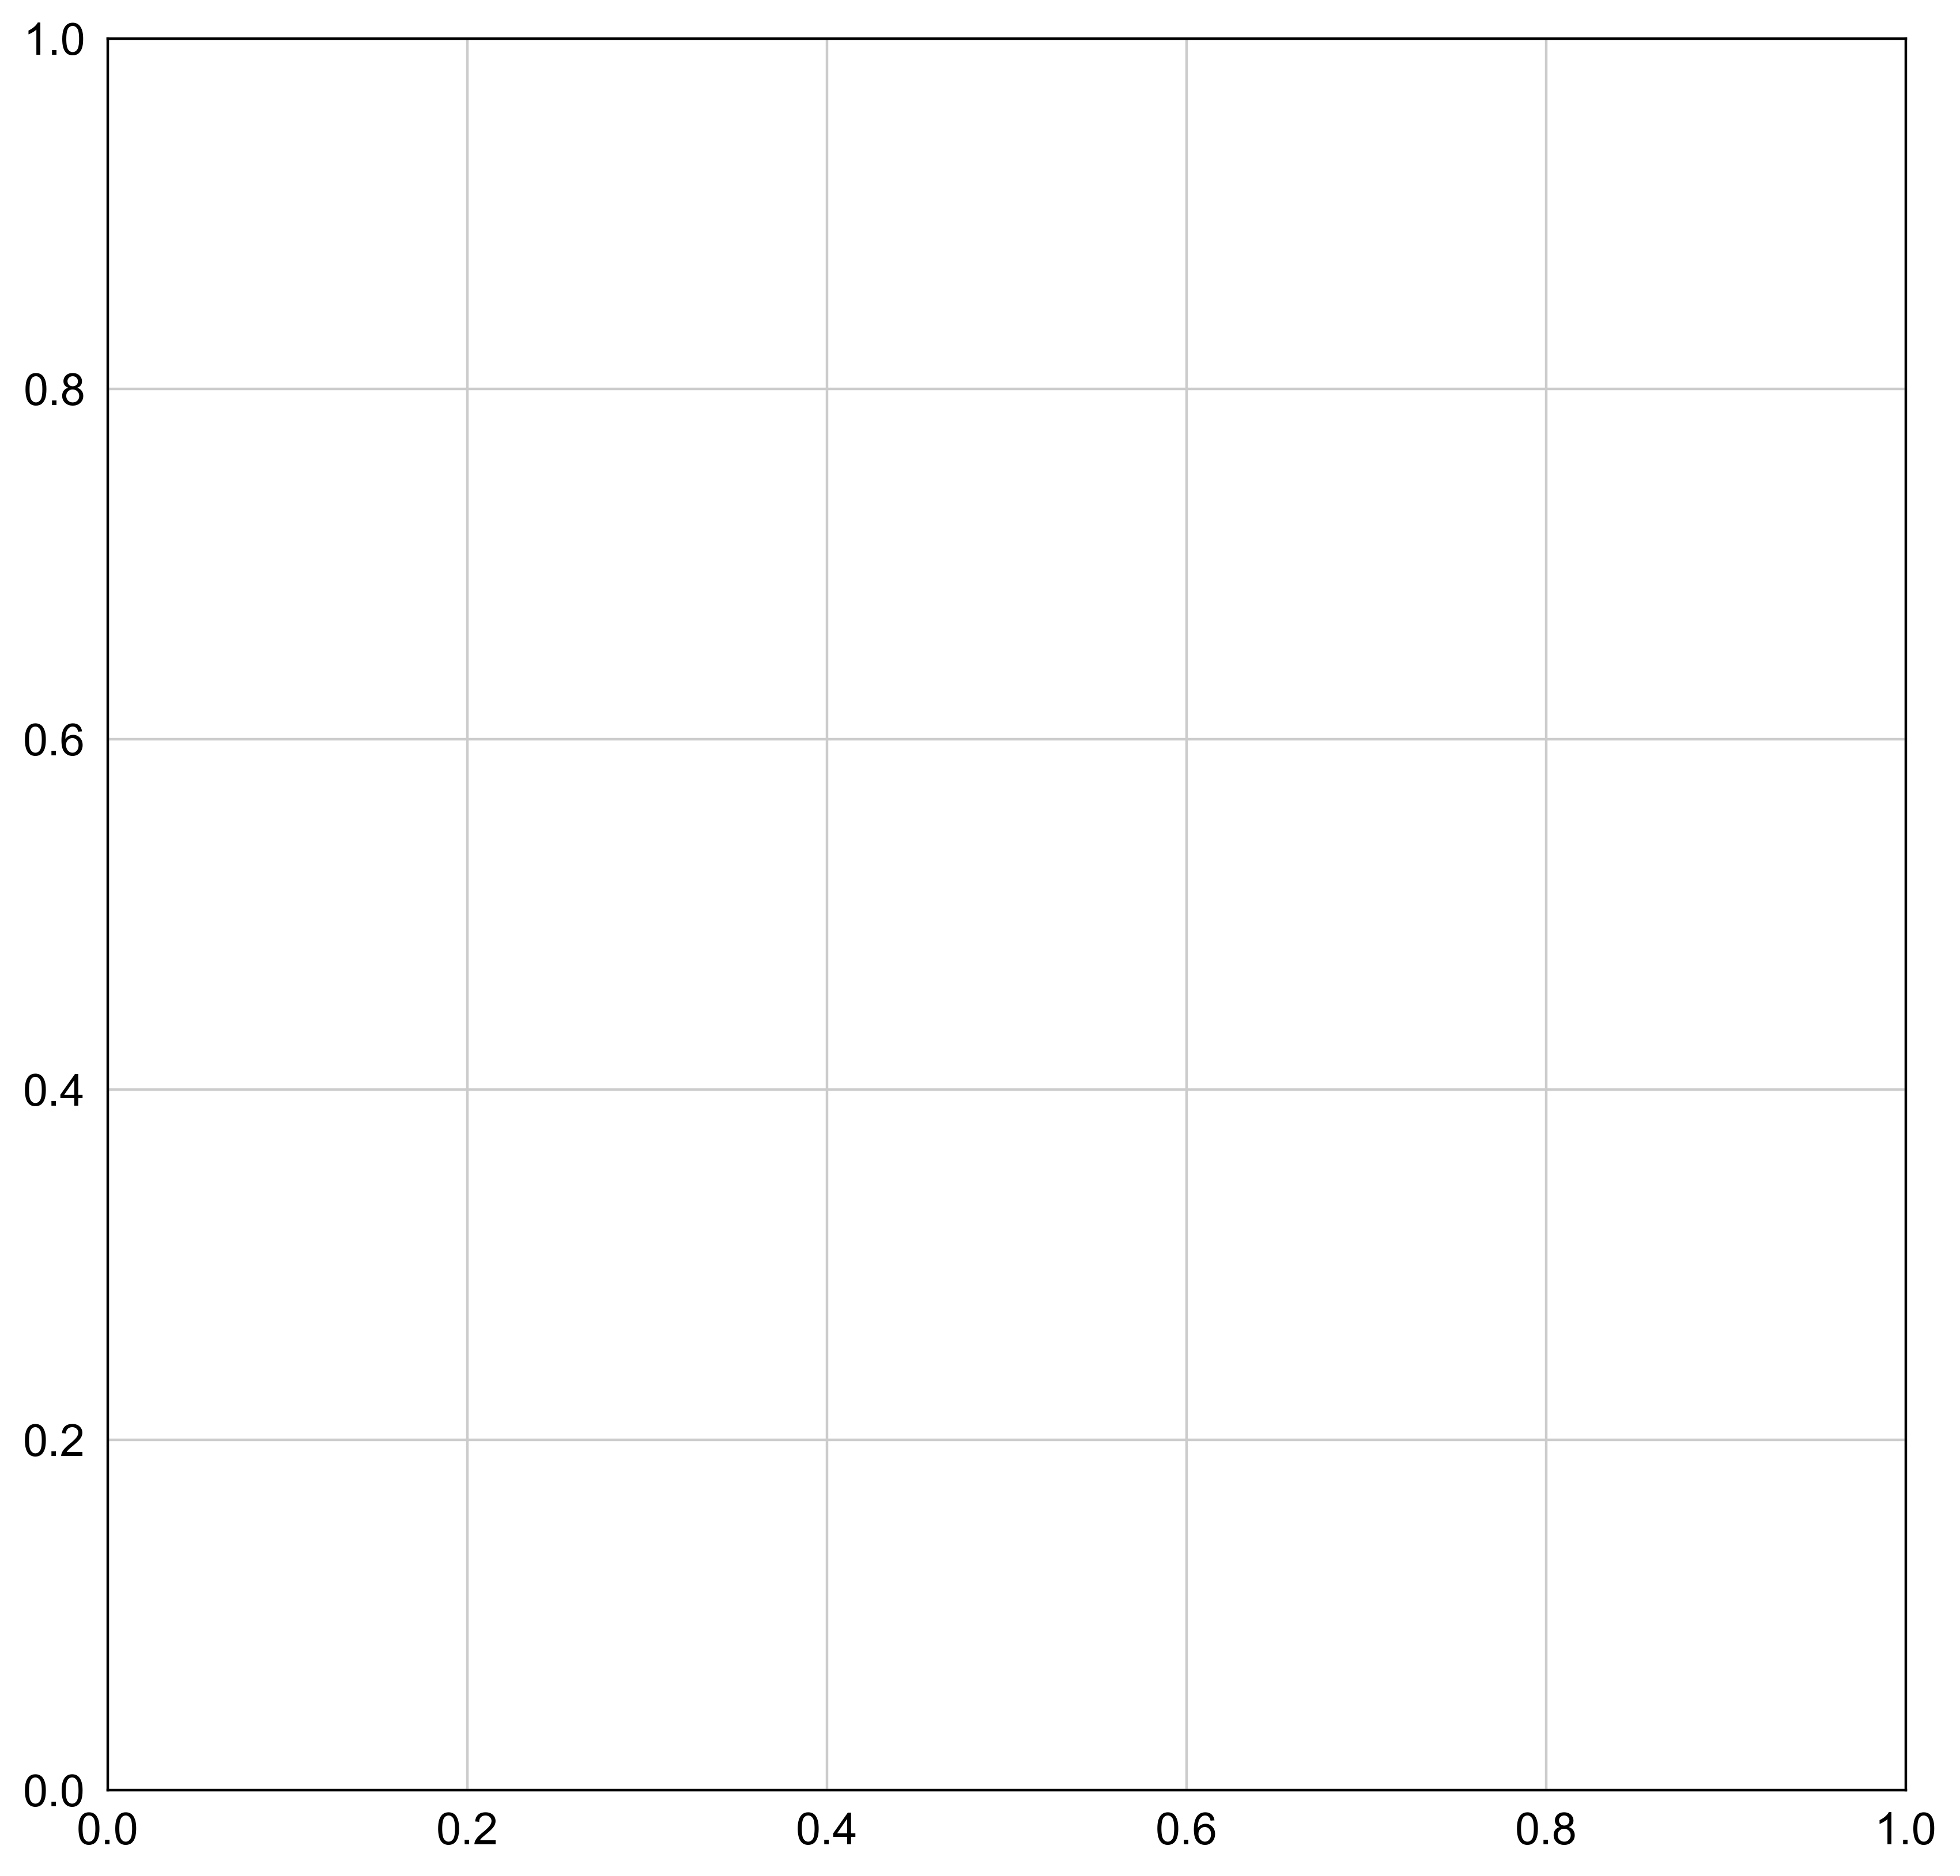

In [63]:
plot_umap(t, "GSE_" + str("temp") + "_harmony", hue = "GSM")

In [5]:
# select highly varied genes on normalized
# top genes that overlap
# seurat_v3 expects raw counts
sc.pp.highly_variable_genes(
    hs_combined,
    flavor = "seurat_v3",
    n_top_genes = 3000,
    # inplace subset
    subset = True
)